In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### read and summarize data

In [2]:
f = '/Users/Aaron_hill/Dropbox/data/ml_20/final_data/toxiccomments_train.csv'
toxic_data = pd.read_csv(f)

In [3]:
print("toxic_data is:", type(toxic_data))
print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
print("the data types for each of the columns in toxic_data:")
print(toxic_data.dtypes, "\n")
print("the first 10 rows in toxic_data:")
print(toxic_data.head(5))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 8 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1     

In [4]:
print("The rate of toxic comments in the dataset: ")
print(toxic_data['toxic'].mean())

The rate of toxic comments in the dataset: 
0.09584448302009764


### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = toxic_data.comment_text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(toxic_data.comment_text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(159571, 131072)


In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")


X_quant_features = toxic_data[["word_count", "punc_count"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   word_count  punc_count
0          42           5
1          18           2
2          42           3
3         112           3
4          13           1
5          12           1
6           8           0
7          21           2
8          83           7
9          12           0
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(159571, 131074)


In [11]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 13080)	0.3352837541940735
  (0, 20637)	0.12273750000524668
  (0, 24734)	0.05756850399552078
  (0, 28641)	0.30255698578348783
  (0, 36157)	0.11300117557573076
  (0, 38365)	0.2858310107057536
  (0, 43099)	0.06265026668613759
  (0, 43902)	0.17992345892724868
  (0, 45980)	0.1435960247305051
  (0, 46353)	0.13568699421838595
  (0, 49453)	0.1384992605089221
  (0, 50743)	0.089351164688054
  (0, 51619)	0.11280487492095764
  (0, 54542)	0.2221009321228698
  (0, 61069)	0.41065661467663855
  (0, 65396)	0.4538351025565183
  (0, 67646)	0.07583345070821097
  (0, 69740)	0.11164777968958645
  (0, 92259)	0.2072488754885471
  (0, 98369)	0.1522711489306622
  (0, 111869)	0.21053732125232136
  (0, 116871)	0.12394931615623446
  (0, 131072)	27.0


### Create `X`, scaled matrix of features

In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

(159571, 131074)


In [13]:
# look at an example of a "row" of a sparse matrix, after scaling
print(X[1234])

  (0, 13080)	38.95725464549216
  (0, 20637)	3.349436911185673
  (0, 24734)	0.8062975449122693
  (0, 28641)	31.749699089684647
  (0, 36157)	2.5467270635628396
  (0, 38365)	25.739199844475827
  (0, 43099)	1.1063300679196704
  (0, 43902)	4.567256101377231
  (0, 45980)	2.023775982828097
  (0, 46353)	4.339988839263545
  (0, 49453)	2.861090888355053
  (0, 50743)	2.211898499002182
  (0, 51619)	2.682705565838809
  (0, 54542)	14.869388917697037
  (0, 61069)	156.62278459891698
  (0, 65396)	217.8938069236664
  (0, 67646)	1.466925670797892
  (0, 69740)	3.340770670659583
  (0, 92259)	11.136250466652653
  (0, 98369)	4.93282853017257
  (0, 111869)	14.510798190159978
  (0, 116871)	3.916806331416094
  (0, 131072)	0.2686035598369133


# Create Training and Test Sets

In [14]:
# IMPORTANT, enter an integer into the variable below; any integer other than 74
my_random_state = 

# create training and test sets
from sklearn.model_selection import train_test_split

# enter an integer for the random_state parameter; any integer will work
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, toxic_data['toxic'], toxic_data, test_size= 0.2, random_state=my_random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_raw_train.shape)
print(X_raw_test.shape)

(127656, 131074)
(31915, 131074)
(127656,)
(31915,)
(127656, 10)
(31915, 10)


# Fit Models

### MODEL: ordinary least squares

In [15]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 5002, 'TN': 45745, 'FP': 46569, 'FN': 4816, 'Accuracy': 0.3312899856378117, 'Precision': 0.09699249578251343, 'Recall': 0.4084599052751919, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [16]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 924, 'TN': 83191, 'FP': 9123, 'FN': 8894, 'Accuracy': 0.5491252121686905, 'Precision': 0.09196775156763212, 'Recall': 0.07545320921117099, 'desc': 'svm_train'}


### MODEL: logistic regression

In [17]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 892, 'TN': 83433, 'FP': 8881, 'FN': 8926, 'Accuracy': 0.5504961483222353, 'Precision': 0.0912718714826563, 'Recall': 0.07284011105667157, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 1764, 'TN': 75622, 'FP': 16692, 'FN': 8054, 'Accuracy': 0.5051965008486747, 'Precision': 0.09557867360208062, 'Recall': 0.144047035766781, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [19]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 928, 'TN': 83174, 'FP': 9140, 'FN': 8890, 'Accuracy': 0.5490403446925186, 'Precision': 0.09217322208978942, 'Recall': 0.07577984648048343, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [20]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=5.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12246.0, 'Neg': 140934.0, 'TP': 765, 'TN': 84762, 'FP': 7552, 'FN': 9053, 'Accuracy': 0.5583431257344301, 'Precision': 0.09198028135144884, 'Recall': 0.06246937775600196, 'desc': 'rdg_train'}


### What is the distribution of weights, OLS vs. ridge? 

In [21]:
print(rdg)

RidgeClassifier(alpha=5.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)


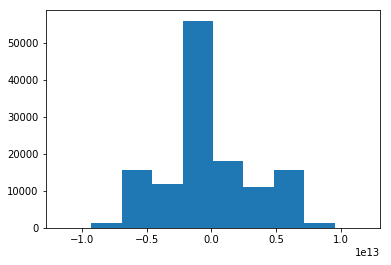

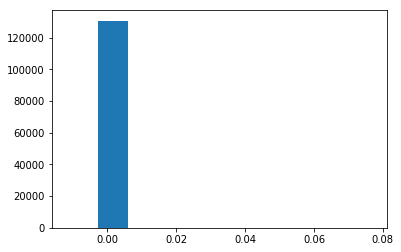

In [22]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### ROC plot to compare performance of various models and fits

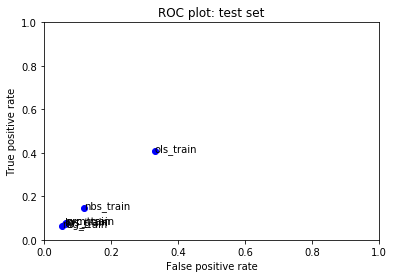

In [23]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [24]:
dir(rdg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_label_binarizer',
 '_predict_proba_lr',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'class_weight',
 'classes_',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'normalize',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [25]:
rdg.get_params()

{'alpha': 5.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [26]:
type(rdg.coef_)

numpy.ndarray

In [27]:
rdg.coef_.shape

(1, 131074)

In [28]:
print(rdg.coef_[0])

[-0.00041558 -0.00092547  0.         ...  0.00021322  0.01402856
  0.00736915]


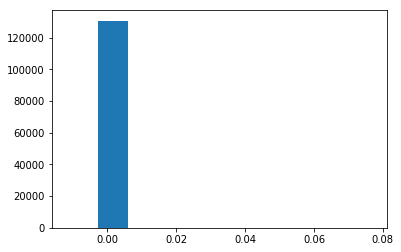

In [29]:
plt.hist(rdg.coef_[0])
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [30]:
toxic_data.loc[0, "comment_text"]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [31]:
ridge_predictions = rdg.predict(X_train)

In [32]:
ridge_predictions.shape

(127656,)

In [33]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (toxic_data.loc[i, "toxic"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(toxic_data.loc[i, "comment_text"])
                print('* * * * * * * * * ')

Examples of false positives:
203
I did research thank you very much, and it is not in the relevance of the article. I think you may have to reseacrh WP:EL to amke sure you realise the facts about why these links are being deleted. I am willing to agree with people that only the official sites should be there, therefore I shall delete the game site and the otehrs now.
* * * * * * * * * 
329
http://www.theatlantic.com/entertainment/archive/2012/02/linsanity-how-the-internet-made-jeremy-lin-a-star-in-less-than-a-week/252755/ Source explaining why he is a star. 198.151.130.68
* * * * * * * * * 
1051
Thanks to all for taking my rather offhand comment seriously.  To reiterate my original explanatoin to James: I'm interested in this more on a meta level (how do we approach controversial subjects) than out of deep feelings one way or the other towards Moore and his film; that is, I'm trying to see the forest of making a good article on the film rather than the trees of every factual detail wit

55428
Proposal for name change/moving the article
It has been suggested on the article for deletion proposal that this article is renamed into List of charismatic leaders as defined by Weber's classification of authority or (incl. Weber's first name) into List of charismatic leaders as defined by Max Weber's classification of authority. Please comment on this if you have objections.
* * * * * * * * * 
56590
Edit request from Scizor319, 21 February 2011 

i have some valuable information on this topic and would love to use it in this page.
* * * * * * * * * 
56973
"
My major takeaways from that discussion were that scholarly sources don't refer to it by the name it was at before, and that it lasted for 700 years. Therefore, it has an excellent claim to being the primary topic for that title, and I didn't feel that the arguments against the move were sufficiently compelling even to close it as ""no consensus"", never mind ""keep at current location"".   "
* * * * * * * * * 
57354
You are

104989
"
 I would have guessed that it was Canadiandy who would be complaining here; take a look at his edit history: how many actual contributions to articles has he made  ? ) His bit here smacks of 'admin shopping' to help his 'cause'.  Cheers  | Talk "
* * * * * * * * * 
105433
"
That's fine about the reference source as to exactly WHY he retired. As for the Lede.  I did what seemed manifest and practical. Instead of ""He's a Rep-elect"" and then a ""He's a member of the Repub party"". Just put ""he's a Repub Rep-elect"". Simple.  And just the couple supplementary facts about who the last black Florida Rep was and the exact year without it being lengthy or taking away from the main subject.  That was it
 "
* * * * * * * * * 
105481
Why have I been blocked. I haven't done anything to warrant it. It seems an abuse of power by the blocker. No wasn't any warnings at all. Please rescind the block. 192.148.117.79
* * * * * * * * * 
105894
" 
And since those posts are lost in the talk page

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [34]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 305, 'TN': 2882, 'FP': 2857, 'FN': 325, 'Accuracy': 0.05546370581785907, 'Precision': 0.09645793801391524, 'Recall': 0.10006561679790026, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [35]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 73, 'TN': 5057, 'FP': 682, 'FN': 557, 'Accuracy': 0.08927794504098432, 'Precision': 0.09668874172185431, 'Recall': 0.023950131233595802, 'desc': 'svm_test'}


### MODEL: logistic regression

In [36]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 78, 'TN': 5076, 'FP': 663, 'FN': 552, 'Accuracy': 0.08969561963766728, 'Precision': 0.10526315789473684, 'Recall': 0.025590551181102362, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [37]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 136, 'TN': 4434, 'FP': 1305, 'FN': 494, 'Accuracy': 0.07953220445171508, 'Precision': 0.09437890353920889, 'Recall': 0.04461942257217848, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [38]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 79, 'TN': 5086, 'FP': 653, 'FN': 551, 'Accuracy': 0.08988705382781365, 'Precision': 0.10792349726775956, 'Recall': 0.025918635170603676, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [39]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3048.0, 'Neg': 54413.0, 'TP': 39, 'TN': 5382, 'FP': 357, 'FN': 591, 'Accuracy': 0.0943422495257653, 'Precision': 0.09848484848484848, 'Recall': 0.012795275590551181, 'desc': 'rdg_test'}


### ROC plot to compare performance of various models and fits

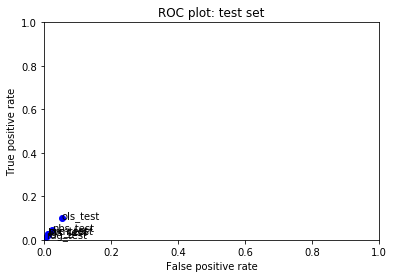

In [40]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()